## Orbital analysis

This section process the preliminary vibration data in different load condition of three bearings on hydropower plant.

### Data extraction

In [13]:
# import all necessary packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
import time
from scipy.signal import butter, buttord, sosfreqz, sosfilt, sosfiltfilt, cheb2ord, cheby2, firwin, freqz, firls, lfilter, iirpeak, filtfilt
from scipy.fft import rfft, irfft, fftfreq

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
from matplotlib import  gridspec


In [14]:
# load the vibration data : 
# 1. High load operational condition on Larona Unit #1 on August 10th, 2023 at 1:00:00 a.m. ; clockwise ; top ; X:0° EU Y:+90° EU 
# 2. Low load operational condition on Larona Unit #1 on October 25th, 2023 at 6:00:00 p.m. ; clockwise ; top ; X:0° EU Y:+90° EU 
# 3. Normal load operational condition on Larona Unit #1 on October 8th, 2023 at 1:00:00 a.m. ; clockwise ; top ; X:0° EU Y:+90° EU 

db_data_hl = pd.read_excel("LGS1_VibrationOrbit_2023_HighLoad.xlsx", sheet_name="Orbit Comparison")
db_data_nl = pd.read_excel("LGS1_VibrationOrbit_2023_NormalLoad.xlsx", sheet_name="Orbit Comparison")
db_data_ll = pd.read_excel("LGS1_VibrationOrbit_2023_LowLoad.xlsx", sheet_name="Orbit Comparison")

In [45]:
# select the database
db_data = db_data_hl

# extract all variables of UGB parameter
# data at 1x rpm
ugb_1x_rev = db_data['UGB – Rev – 1X']
ugb_1x_time = db_data['UGB – Time – 1X']
ugb_1x_x = db_data['UGB – Disp – 1X – X']
ugb_1x_y = db_data['UGB – Disp – 1X – Y']

# data on overall spectrum
ugb_ovr_rev = db_data['UGB – Rev – Overall']
ugb_ovr_time = db_data['UGB – Time – Overall']
ugb_ovr_x = db_data['UGB – Disp – Overall – X']
ugb_ovr_y = db_data['UGB – Disp – Overall – Y']

# extract all variables of LGB parameter
# data at 1x rpm
lgb_1x_rev = db_data['LGB – Rev – 1X']
lgb_1x_time = db_data['LGB – Time – 1X']
lgb_1x_x = db_data['LGB – Disp – 1X – X']
lgb_1x_y = db_data['LGB – Disp – 1X – Y']

# data on overall spectrum
lgb_ovr_rev = db_data['LGB – Rev – Overall']
lgb_ovr_time = db_data['LGB – Time – Overall']
lgb_ovr_x = db_data['LGB – Disp – Overall – X']
lgb_ovr_y = db_data['LGB – Disp – Overall – Y']

# extract all variables of TGB parameter
# data at 1x rpm
tgb_1x_rev = db_data['TGB – Rev – 1X']
tgb_1x_time = db_data['TGB – Time – 1X']
tgb_1x_x = db_data['TGB – Disp – 1X – X']
tgb_1x_y = db_data['TGB – Disp – 1X – Y']

# data on overall spectrum
tgb_ovr_rev = db_data['TGB – Rev – Overall']
tgb_ovr_time = db_data['TGB – Time – Overall']
tgb_ovr_x = db_data['TGB – Disp – Overall – X']
tgb_ovr_y = db_data['TGB – Disp – Overall – Y']

### Data Visualization

#### Defined function
This section contains all self-defined function for plot and visualize the data from Vibro-Sight Vision

In [79]:
# plot time series data
def plot_time_series(ax, time_data, value_data, rev_data, xlim, title):
    # plot time series data
    ax.plot(time_data, value_data)
    
    # create rev. marker
    val = 0
    for i in range(len(rev_data)):
        val_new = np.floor(rev_data[i])
        if val_new == val + 1:
            ax.plot(time_data[i], value_data[i], 'bo')
            val = val_new

    ax.set_xlabel("Time (s)")
    ax.set_ylabel(u"Displacement (\u03bcm)")
    ax.grid(which='both')
    ax.set_xlim(xlim)
    ax.set_title(title)

def plot_orbit(ax, x_data, y_data, x_lim, ylim, title):
    # plot orbital data
    ax.plot(x_data, y_data)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_xlabel(u"X-displacement (\u03bcm)")
    ax.set_xlabel(u"Y-displacement (\u03bcm)")
    ax.grid(which='both')

# define spectrum calculation of the displacement data
def fft_signal(time_data, value_data):
    # create window
    # win = np.hanning(len(value_data))

    # create frequency axis data
    freq = np.fft.fftfreq(len(value_data), time_data[1]-time_data[0])

    # apply fft
    spec = (2/len(value_data)) * np.fft.fft(value_data)

    return freq, spec

def plot_spectrum(freq_data, spec_data):
    idx = int(len(freq_data)/2)
    amp = np.abs(spec_data)
    phase = np.angle(spec_data)

    phase[amp < 1] = 0

    fig = plt.figure()
    ax_amp = fig.add_subplot(211)
    ax_amp.plot(freq_data[:idx], amp[:idx])
    ax_amp.set_xlim([0, 25])
    ax_amp.set_xlabel("Frequency (Hz)")
    ax_amp.set_ylabel(u"Magnitude (\u03bcm)")
    ax_amp.set_title("Magnitude of Spectrum Vibration Data")
    plt.grid(True)

    ax_phase = fig.add_subplot(212)
    ax_phase.plot(freq_data[:idx], phase[:idx])
    ax_phase.set_xlim([0, 25])
    ax_phase.set_xlabel("Frequency (Hz)")
    ax_phase.set_ylabel(u"Phase (radians)")
    ax_phase.set_title("Phase of Spectrum Vibration Data")
    plt.grid(True)

    plt.tight_layout()


#### Visualize the Data
The we visualize the data

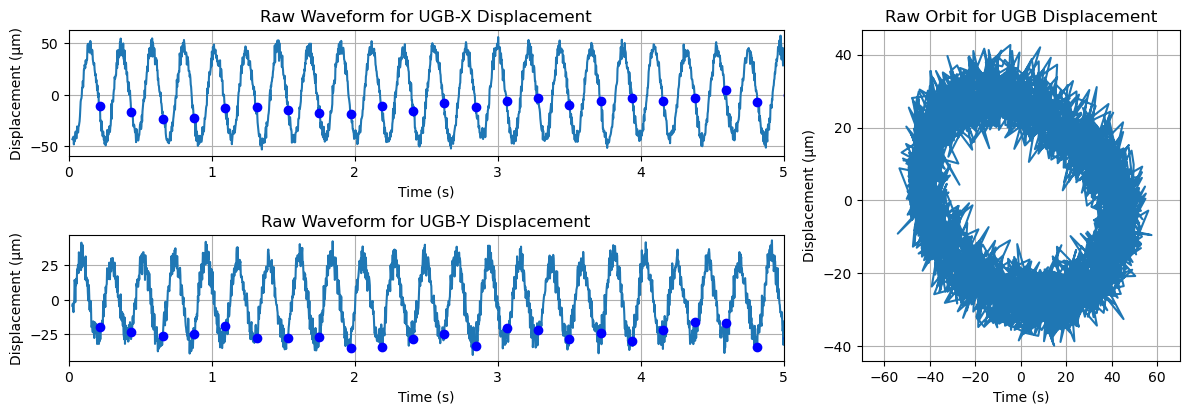

In [81]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

ax_UGB_time_x = plt.subplot2grid(shape=(6, 6), loc=(0, 0), colspan=4)
ax_UGB_time_y = plt.subplot2grid(shape=(6, 6), loc=(1, 0), colspan=4)
ax_UGB_orbit = plt.subplot2grid(shape=(6, 6), loc=(0, 4), rowspan=2, colspan=2)

plot_time_series(ax_UGB_time_x, ugb_ovr_time, ugb_ovr_x, ugb_ovr_rev, [0,5], "Raw Waveform for UGB-X Displacement")
plot_time_series(ax_UGB_time_y, ugb_ovr_time, ugb_ovr_y, ugb_ovr_rev, [0,5], "Raw Waveform for UGB-Y Displacement")
plot_time_series(ax_UGB_orbit, ugb_ovr_x, ugb_ovr_y, [-70,70], [-70,70], "Raw Orbit for UGB Displacement")

plt.tight_layout()
plt.show()

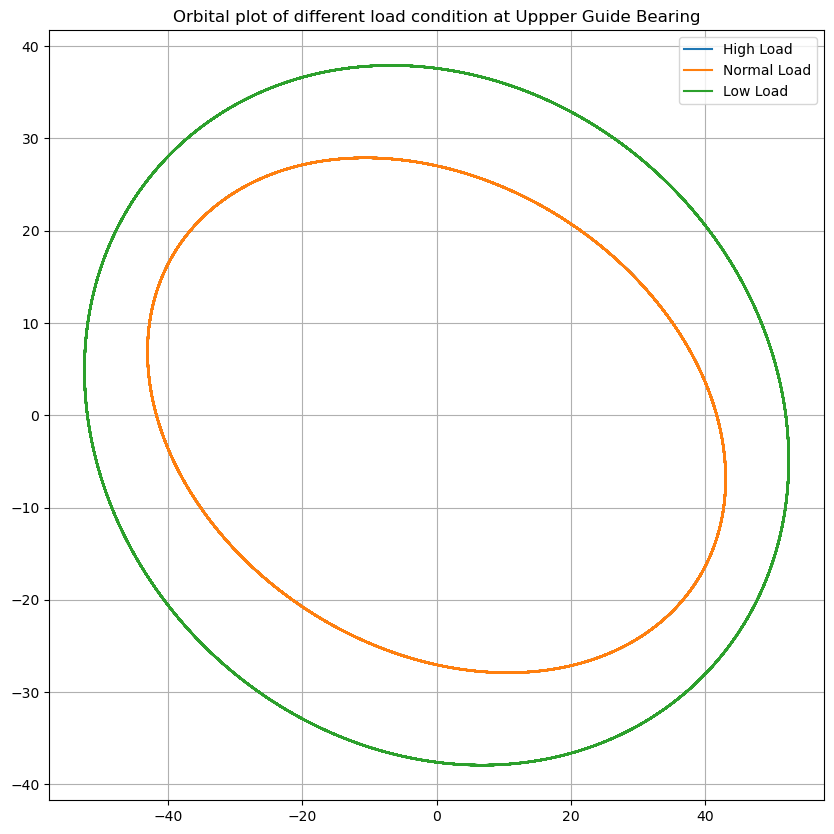

In [6]:
# create and plot the vibration data
ugb_hl_1x_time = db_data_hl['UGB – Time – 1X']
ugb_hl_1x_x = db_data_hl['UGB – Disp – 1X – X']
ugb_hl_1x_y = db_data_hl['UGB – Disp – 1X – Y']

ugb_nl_1x_time = db_data_nl['UGB – Time – 1X']
ugb_nl_1x_x = db_data_nl['UGB – Disp – 1X – X']
ugb_nl_1x_y = db_data_nl['UGB – Disp – 1X – Y']

ugb_ll_1x_time = db_data_ll['UGB – Time – 1X']
ugb_ll_1x_x = db_data_ll['UGB – Disp – 1X – X']
ugb_ll_1x_y = db_data_ll['UGB – Disp – 1X – Y']

# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax.plot(ugb_hl_1x_x, ugb_hl_1x_y)
ax.plot(ugb_nl_1x_x, ugb_nl_1x_y)
ax.plot(ugb_ll_1x_x, ugb_ll_1x_y)
ax.set_title("Orbital plot of different load condition at Uppper Guide Bearing")
ax.legend(['High Load', 'Normal Load', 'Low Load'])
plt.grid()

plt.show()   

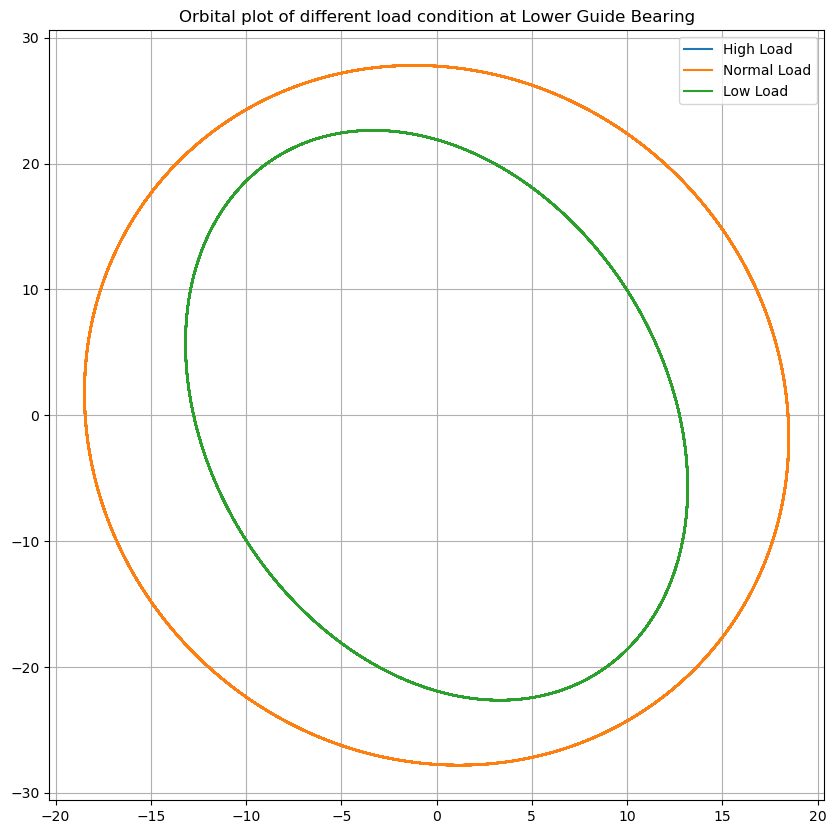

In [7]:
# create and plot the vibration data
lgb_hl_1x_time = db_data_hl['LGB – Time – 1X']
lgb_hl_1x_x = db_data_hl['LGB – Disp – 1X – X']
lgb_hl_1x_y = db_data_hl['LGB – Disp – 1X – Y']

lgb_nl_1x_time = db_data_nl['LGB – Time – 1X']
lgb_nl_1x_x = db_data_nl['LGB – Disp – 1X – X']
lgb_nl_1x_y = db_data_nl['LGB – Disp – 1X – Y']

lgb_ll_1x_time = db_data_ll['LGB – Time – 1X']
lgb_ll_1x_x = db_data_ll['LGB – Disp – 1X – X']
lgb_ll_1x_y = db_data_ll['LGB – Disp – 1X – Y']

# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax.plot(lgb_hl_1x_x, lgb_hl_1x_y)
ax.plot(lgb_nl_1x_x, lgb_nl_1x_y)
ax.plot(lgb_ll_1x_x, lgb_ll_1x_y)
ax.set_title("Orbital plot of different load condition at Lower Guide Bearing")
ax.legend(['High Load', 'Normal Load', 'Low Load'])
plt.grid()

plt.show()  

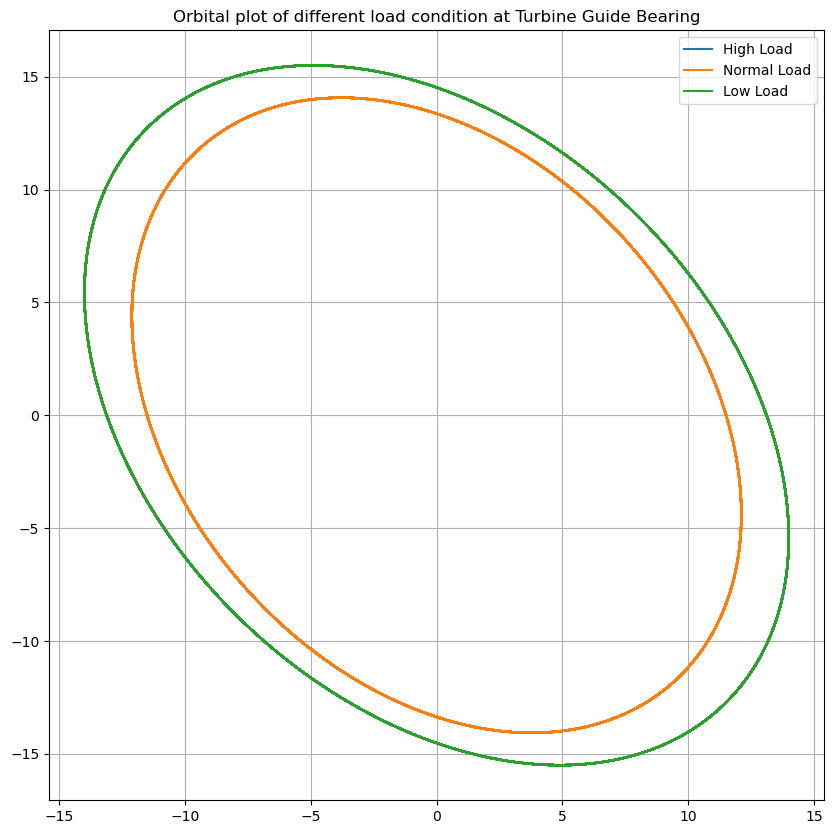

In [18]:
# create and plot the vibration data
tgb_hl_1x_time = db_data_hl['TGB – Time – 1X']
tgb_hl_1x_x = db_data_hl['TGB – Disp – 1X – X']
tgb_hl_1x_y = db_data_hl['TGB – Disp – 1X – Y']

# create and plot the vibration data
tgb_hl_ovr_rev = db_data_hl['TGB – Rev – Overall']
tgb_hl_ovr_time = db_data_hl['TGB – Time – Overall']
tgb_hl_ovr_x = db_data_hl['TGB – Disp – Overall – X']
tgb_hl_ovr_y = db_data_hl['TGB – Disp – Overall – Y']

tgb_nl_1x_time = db_data_nl['TGB – Time – 1X']
tgb_nl_1x_x = db_data_nl['TGB – Disp – 1X – X']
tgb_nl_1x_y = db_data_nl['TGB – Disp – 1X – Y']

tgb_ll_1x_time = db_data_ll['TGB – Time – 1X']
tgb_ll_1x_x = db_data_ll['TGB – Disp – 1X – X']
tgb_ll_1x_y = db_data_ll['TGB – Disp – 1X – Y']

# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax.plot(tgb_hl_1x_x, tgb_hl_1x_y)
ax.plot(tgb_nl_1x_x, tgb_nl_1x_y)
ax.plot(tgb_ll_1x_x, tgb_ll_1x_y)
ax.set_title("Orbital plot of different load condition at Turbine Guide Bearing")
ax.legend(['High Load', 'Normal Load', 'Low Load'])
plt.grid()

plt.show()  

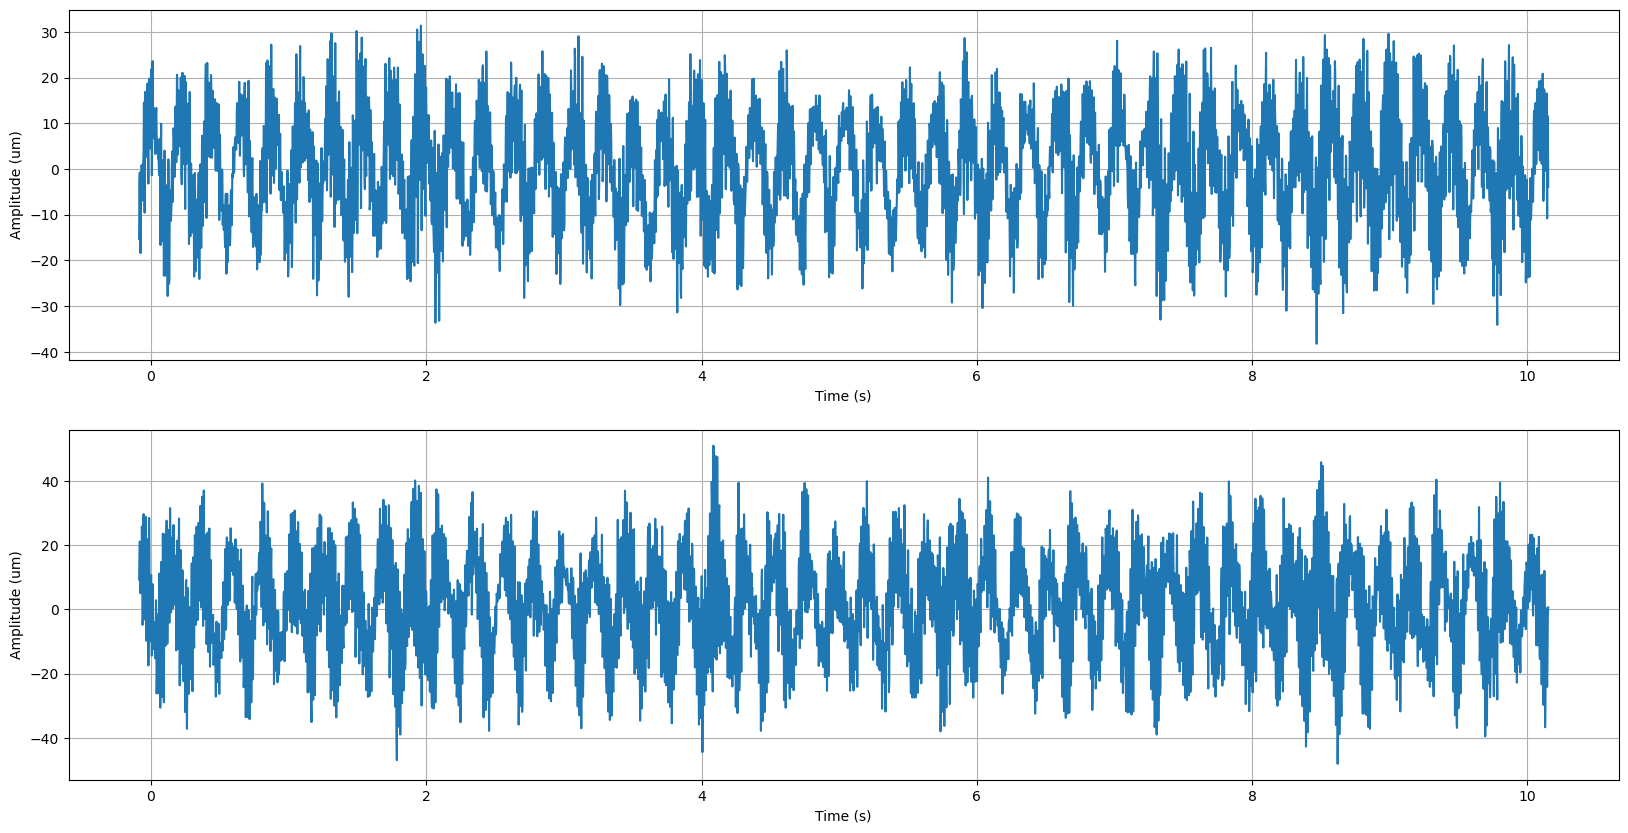

In [24]:
# plot the 2D sine wave of each displacement axis
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(211)
val = 0
for i in range(len(tgb_hl_ovr_rev)):
    val_new = np.floor(tgb_hl_ovr_rev[i])
    if val_new == val + 1:
        #ax.plot(tgb_hl_ovr_time[i], tgb_hl_ovr_x[i], 'ro')
        val = val_new
ax.plot(tgb_hl_ovr_time, tgb_hl_ovr_x)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (um)")
plt.grid()

ax = fig.add_subplot(212)
val = 0
for i in range(len(tgb_hl_ovr_rev)):
    val_new = np.floor(tgb_hl_ovr_rev[i])
    if val_new == val + 1:
        #ax.plot(tgb_hl_ovr_time[i], tgb_hl_ovr_y[i], 'ro')
        val = val_new
ax.plot(tgb_hl_ovr_time, tgb_hl_ovr_y)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (um)")
plt.grid()

plt.show()


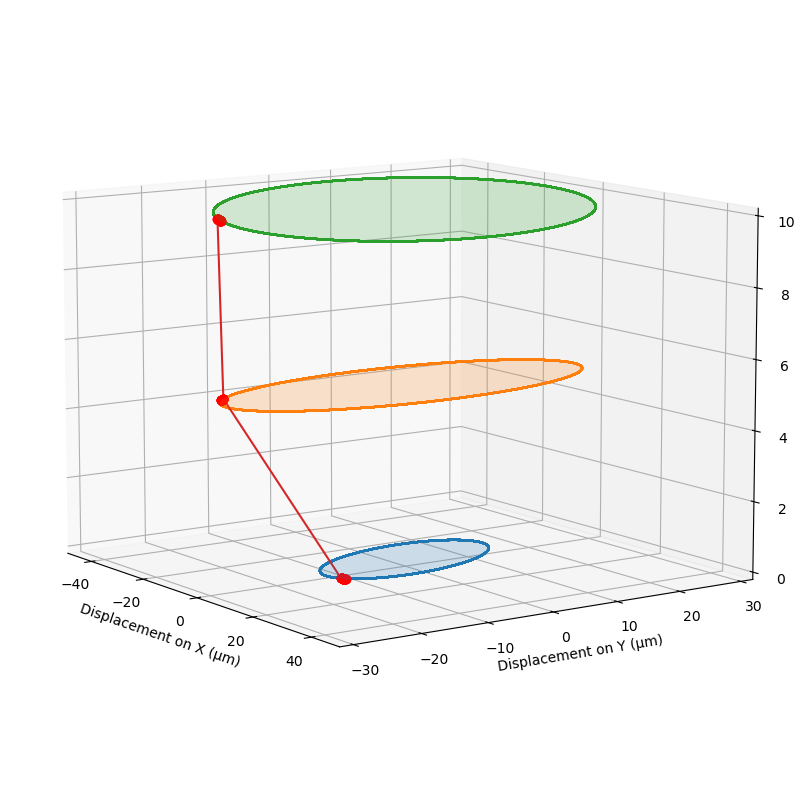

In [10]:
def plot2din3d(x, y, z):
    ax.plot(x, y, zs=z, zdir='z')
    col_obj = ax.fill_between(x, 0.5, y, step='pre', alpha=0.1)
    ax.add_collection3d(col_obj, zs=z, zdir='z')  

# try to plot the orbital plot into 3d projection
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

z_axis = [0, 5, 10]

# plot the orbital curve
plot2din3d(tgb_hl_1x_x, tgb_hl_1x_y, z_axis[0])
plot2din3d(lgb_hl_1x_x, lgb_hl_1x_y, z_axis[1])
plot2din3d(ugb_hl_1x_x, ugb_hl_1x_y, z_axis[2])

# plot the shaft line projection
ax.plot([ugb_hl_1x_x[0], lgb_hl_1x_x[0], tgb_hl_1x_x[0]], [ugb_hl_1x_y[0], lgb_hl_1x_y[0], tgb_hl_1x_y[0]], [10, 5, 0])

# plot the revolution mark
tgb_hl_1x_rev = db_data_hl['TGB – Rev – 1X']
lgb_hl_1x_rev = db_data_hl['LGB – Rev – 1X']
ugb_hl_1x_rev = db_data_hl['UGB – Rev – 1X']

val = 0
for i in range(len(tgb_hl_1x_rev)):
    val_new = np.floor(tgb_hl_1x_rev[i])
    if val_new == val + 1:
        ax.plot(tgb_hl_1x_x[i], tgb_hl_1x_y[i], z_axis[0], 'ro')
        val = val_new

val = 0
for i in range(len(lgb_hl_1x_rev)):
    val_new = np.floor(lgb_hl_1x_rev[i])
    if val_new == val + 1:
        ax.plot(lgb_hl_1x_x[i], lgb_hl_1x_y[i], z_axis[1], 'ro')
        val = val_new

val = 0
for i in range(len(ugb_hl_1x_rev)):
    val_new = np.floor(ugb_hl_1x_rev[i])
    if val_new == val + 1:
        ax.plot(ugb_hl_1x_x[i], ugb_hl_1x_y[i], z_axis[2], 'ro')
        val = val_new

# add axis information
ax.set_xlabel('Displacement on X (µm)')
ax.set_ylabel('Displacement on Y (µm)')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=-35)

plt.show()

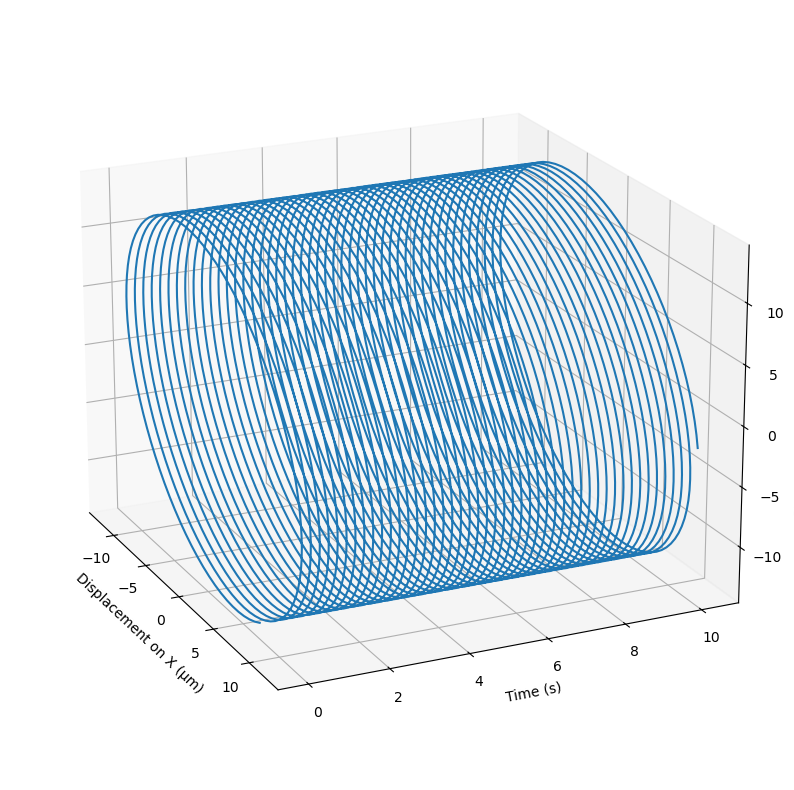

In [41]:
# try to plot the orbital plot into 3d projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.plot3D(tgb_hl_1x_x, tgb_hl_1x_time, tgb_hl_1x_y)

ax.set_xlabel('Displacement on X (µm)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Displacement on Y (µm)')
ax.view_init(elev=20, azim=-25)

plt.tight_layout()
plt.show()

In [ ]:
def plot2din3d(x, y, z):
    ax.plot(x, y, zs=z, zdir='z')
    col_obj = ax.fill_between(x, 0.5, y, step='pre', alpha=0.1)
    ax.add_collection3d(col_obj, zs=z, zdir='z')  

# try to plot the orbital plot into 3d projection
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

z_axis = [0, 5, 10]

# plot the orbital curve
plot2din3d(tgb_hl_1x_x, tgb_hl_1x_y, z_axis[0])
plot2din3d(lgb_hl_1x_x, lgb_hl_1x_y, z_axis[1])
plot2din3d(ugb_hl_1x_x, ugb_hl_1x_y, z_axis[2])

# plot the shaft line projection
ax.plot([ugb_hl_1x_x[0], lgb_hl_1x_x[0], tgb_hl_1x_x[0]], [ugb_hl_1x_y[0], lgb_hl_1x_y[0], tgb_hl_1x_y[0]], [10, 5, 0])

# plot the revolution mark
tgb_hl_1x_rev = db_data_hl['TGB – Rev – 1X']
lgb_hl_1x_rev = db_da ta_hl['LGB – Rev – 1X']
ugb_hl_1x_rev = db_data_hl['UGB – Rev – 1X']

val = 0
for i in range(len(tgb_hl_1x_rev)):
    val_new = np.floor(tgb_hl_1x_rev[i])
    if val_new == val + 1:
        ax.plot(tgb_hl_1x_x[i], tgb_hl_1x_y[i], z_axis[0], 'ro')
        val = val_new

val = 0
for i in range(len(lgb_hl_1x_rev)):
    val_new = np.floor(lgb_hl_1x_rev[i])
    if val_new == val + 1:
        ax.plot(lgb_hl_1x_x[i], lgb_hl_1x_y[i], z_axis[1], 'ro')
        val = val_new

val = 0
for i in range(len(ugb_hl_1x_rev)):
    val_new = np.floor(ugb_hl_1x_rev[i])
    if val_new == val + 1:
        ax.plot(ugb_hl_1x_x[i], ugb_hl_1x_y[i], z_axis[2], 'ro')
        val = val_new

# add axis information
ax.set_xlabel('Displacement on X (µm)')
ax.set_ylabel('Displacement on Y (µm)')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=-35)

plt.show()

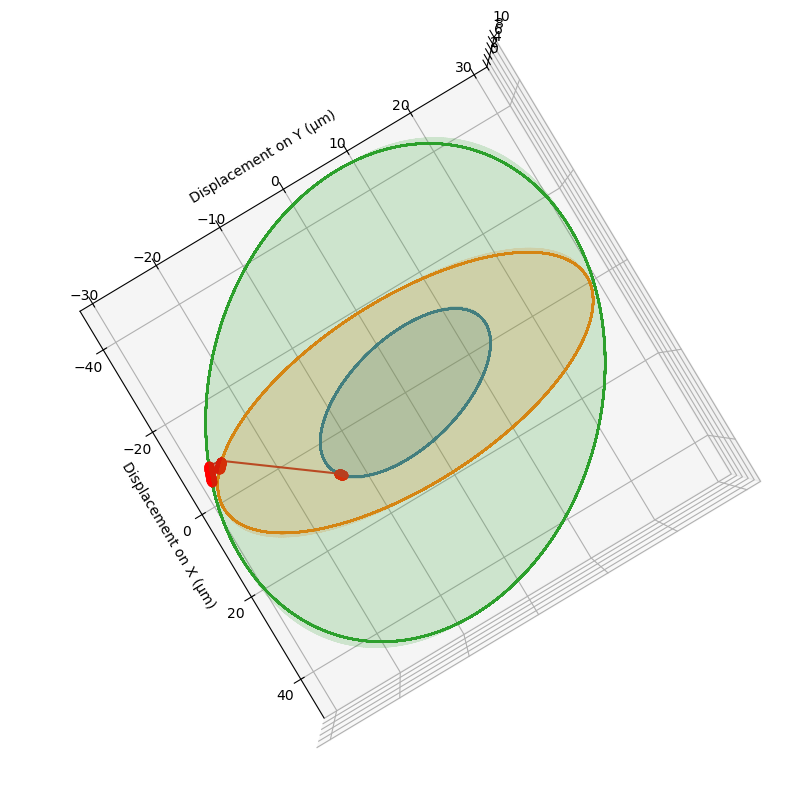

In [11]:
def plot2din3d(x, y, z):
    ax.plot(x, y, zs=z, zdir='z')
    col_obj = ax.fill_between(x, 0.5, y, step='pre', alpha=0.1)
    ax.add_collection3d(col_obj, zs=z, zdir='z')  

# try to plot the orbital plot into 3d projection
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

z_axis = [0, 5, 10]

# plot the orbital curve
plot2din3d(tgb_hl_1x_x, tgb_hl_1x_y, z_axis[0])
plot2din3d(lgb_hl_1x_x, lgb_hl_1x_y, z_axis[1])
plot2din3d(ugb_hl_1x_x, ugb_hl_1x_y, z_axis[2])

# plot the shaft line projection
ax.plot([ugb_hl_1x_x[0], lgb_hl_1x_x[0], tgb_hl_1x_x[0]], [ugb_hl_1x_y[0], lgb_hl_1x_y[0], tgb_hl_1x_y[0]], [10, 5, 0])

# plot the revolution mark
tgb_hl_1x_rev = db_data_hl['TGB – Rev – 1X']
lgb_hl_1x_rev = db_data_hl['LGB – Rev – 1X']
ugb_hl_1x_rev = db_data_hl['UGB – Rev – 1X']

val = 0
for i in range(len(tgb_hl_1x_rev)):
    val_new = np.floor(tgb_hl_1x_rev[i])
    if val_new == val + 1:
        ax.plot(tgb_hl_1x_x[i], tgb_hl_1x_y[i], z_axis[0], 'ro')
        val = val_new

val = 0
for i in range(len(lgb_hl_1x_rev)):
    val_new = np.floor(lgb_hl_1x_rev[i])
    if val_new == val + 1:
        ax.plot(lgb_hl_1x_x[i], lgb_hl_1x_y[i], z_axis[1], 'ro')
        val = val_new

val = 0
for i in range(len(ugb_hl_1x_rev)):
    val_new = np.floor(ugb_hl_1x_rev[i])
    if val_new == val + 1:
        ax.plot(ugb_hl_1x_x[i], ugb_hl_1x_y[i], z_axis[2], 'ro')
        val = val_new

# add axis information
ax.set_xlabel('Displacement on X (µm)')
ax.set_ylabel('Displacement on Y (µm)')
ax.set_zlabel('Z')
ax.view_init(elev=90, azim=-35)

plt.show()

## try to recap all orbital visualization and analysis of vibration data in one figure

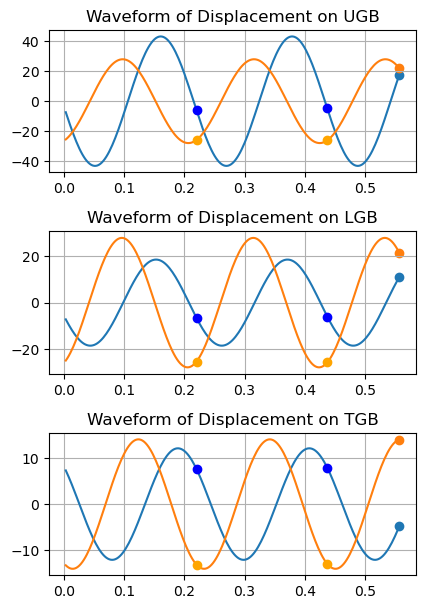

KeyboardInterrupt: 

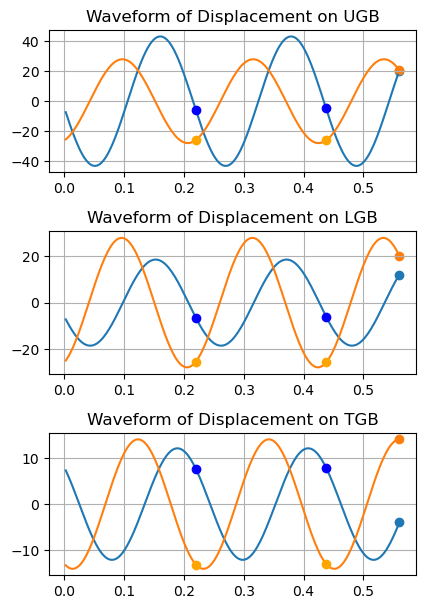

In [12]:
# list all variable

ugb_hl_1x_rev = db_data_hl['UGB – Rev – 1X']
ugb_hl_1x_time = db_data_hl['UGB – Time – 1X']
ugb_hl_1x_x = db_data_hl['UGB – Disp – 1X – X']
ugb_hl_1x_y = db_data_hl['UGB – Disp – 1X – Y']

lgb_hl_1x_rev = db_data_hl['LGB – Rev – 1X']
lgb_hl_1x_time = db_data_hl['LGB – Time – 1X']
lgb_hl_1x_x = db_data_hl['LGB – Disp – 1X – X']
lgb_hl_1x_y = db_data_hl['LGB – Disp – 1X – Y']

tgb_hl_1x_rev = db_data_hl['TGB – Rev – 1X']
tgb_hl_1x_time = db_data_hl['TGB – Time – 1X']
tgb_hl_1x_x = db_data_hl['TGB – Disp – 1X – X']
tgb_hl_1x_y = db_data_hl['TGB – Disp – 1X – Y']

# prepare figure space
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

# create the iteration
counter = 0
val = 0

ugb_trev = []
ugb_xrev = []
ugb_yrev = []
ugb_t= []
ugb_x = []
ugb_y = []

lgb_trev = []
lgb_xrev = []
lgb_yrev = []
lgb_t= []
lgb_x = []
lgb_y = []

tgb_trev = []
tgb_xrev = []
tgb_yrev = []
tgb_t= []
tgb_x = []
tgb_y = []

for i in range(len(ugb_hl_1x_time)):
    counter += 1

    ax_UGB = plt.subplot2grid(shape=(6, 6), loc=(0, 0), colspan=2)
    ax_UGB.scatter(ugb_hl_1x_time[i], ugb_hl_1x_x[i])
    ax_UGB.scatter(ugb_hl_1x_time[i], ugb_hl_1x_y[i])
    ax_UGB.set_title("Waveform of Displacement on UGB")
    plt.grid()

    ax_LGB = plt.subplot2grid(shape=(6, 6), loc=(1, 0), colspan=2)
    ax_LGB.scatter(lgb_hl_1x_time[i], lgb_hl_1x_x[i])
    ax_LGB.scatter(lgb_hl_1x_time[i], lgb_hl_1x_y[i])
    ax_LGB.set_title("Waveform of Displacement on LGB")
    plt.grid()

    ax_TGB = plt.subplot2grid(shape=(6, 6), loc=(2, 0), colspan=2)
    ax_TGB.scatter(tgb_hl_1x_time[i], tgb_hl_1x_x[i])
    ax_TGB.scatter(tgb_hl_1x_time[i], tgb_hl_1x_y[i])
    ax_TGB.set_title("Waveform of Displacement on TGB")
    plt.grid()

    val_new = np.floor(ugb_hl_1x_rev[i])
    if val_new == val + 1:
        ugb_trev.append(ugb_hl_1x_time[i])
        ugb_xrev.append(ugb_hl_1x_x[i])
        ugb_yrev.append(ugb_hl_1x_y[i])

        lgb_trev.append(lgb_hl_1x_time[i])
        lgb_xrev.append(lgb_hl_1x_x[i])
        lgb_yrev.append(lgb_hl_1x_y[i])

        tgb_trev.append(tgb_hl_1x_time[i])
        tgb_xrev.append(tgb_hl_1x_x[i])
        tgb_yrev.append(tgb_hl_1x_y[i])

        val = val_new
    
    if i > 0:
        ax_UGB.plot(ugb_t, ugb_x)
        ax_UGB.plot(ugb_t, ugb_y)
        ax_UGB.plot(ugb_trev, ugb_xrev, 'o', color='blue')
        ax_UGB.plot(ugb_trev, ugb_yrev, 'o', color='orange')
        
        ax_LGB.plot(lgb_t, lgb_x)
        ax_LGB.plot(lgb_t, lgb_y)
        ax_LGB.plot(lgb_trev, lgb_xrev, 'o', color='blue')
        ax_LGB.plot(lgb_trev, lgb_yrev, 'o', color='orange')
        
        ax_TGB.plot(tgb_t, tgb_x)
        ax_TGB.plot(tgb_t, tgb_y)
        ax_TGB.plot(tgb_trev, tgb_xrev, 'o', color='blue')
        ax_TGB.plot(tgb_trev, tgb_yrev, 'o', color='orange')

    ugb_t.append(ugb_hl_1x_time[i])
    ugb_x.append(ugb_hl_1x_x[i])
    ugb_y.append(ugb_hl_1x_y[i])

    lgb_t.append(lgb_hl_1x_time[i])
    lgb_x.append(lgb_hl_1x_x[i])
    lgb_y.append(lgb_hl_1x_y[i])

    tgb_t.append(tgb_hl_1x_time[i])
    tgb_x.append(tgb_hl_1x_x[i])
    tgb_y.append(tgb_hl_1x_y[i])

    plt.tight_layout()
    
    plt.show

    display.clear_output(wait=True)
    display.display(fig)
    time.sleep(0.1)
    plt.clf()


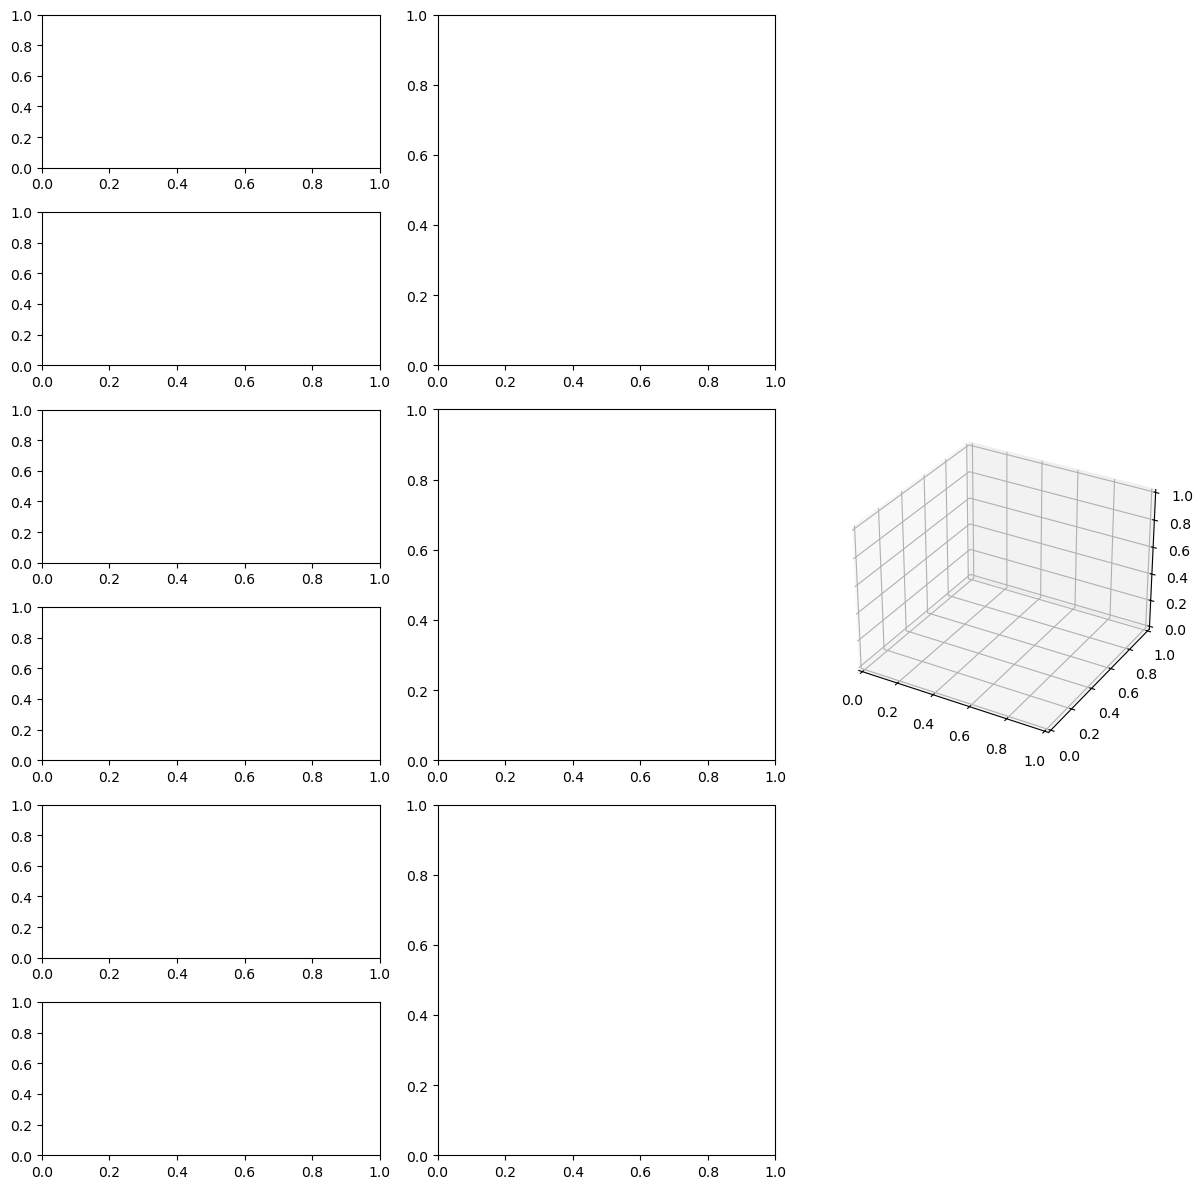

In [46]:
# prepare figure space
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

ax_UGBx = plt.subplot2grid(shape=(6, 6), loc=(0, 0), colspan=2)
ax_UGBy = plt.subplot2grid(shape=(6, 6), loc=(1, 0), colspan=2)
ax_UGBo = plt.subplot2grid(shape=(6, 6), loc=(0, 2), rowspan=2, colspan=2)

ax_LGBx = plt.subplot2grid(shape=(6, 6), loc=(2, 0), colspan=2)
ax_LGBy = plt.subplot2grid(shape=(6, 6), loc=(3, 0), colspan=2)
ax_LGBo = plt.subplot2grid(shape=(6, 6), loc=(2, 2), rowspan=2, colspan=2)

ax_TGBx = plt.subplot2grid(shape=(6, 6), loc=(4, 0), colspan=2)
ax_TGBy = plt.subplot2grid(shape=(6, 6), loc=(5, 0), colspan=2)
ax_TGBo = plt.subplot2grid(shape=(6, 6), loc=(4, 2), rowspan=2, colspan=2)

ax_SFTo = plt.subplot2grid(shape=(6, 6), loc=(0, 4), rowspan=6, colspan=3, projection='3d')

plt.tight_layout()
plt.show()

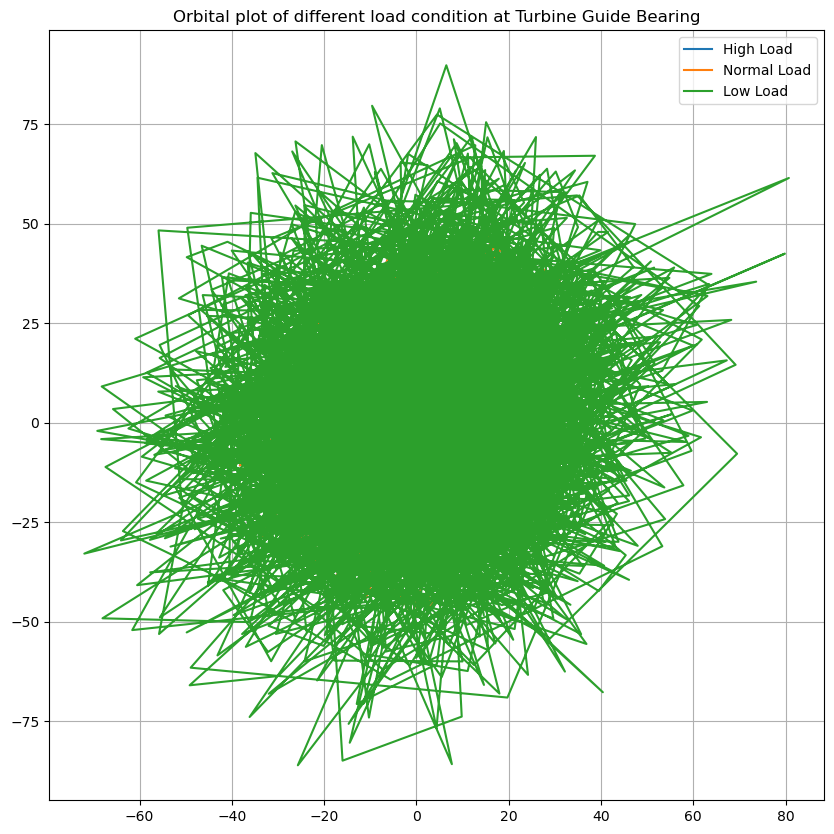

In [7]:
# create and plot the vibration data
tgb_hl_ovr_time = db_data_hl['TGB – Time – Overall']
tgb_hl_ovr_x = db_data_hl['TGB – Disp – Overall – X']
tgb_hl_ovr_y = db_data_hl['TGB – Disp – Overall – Y']

tgb_nl_ovr_time = db_data_nl['TGB – Time – Overall']
tgb_nl_ovr_x = db_data_nl['TGB – Disp – Overall – X']
tgb_nl_ovr_y = db_data_nl['TGB – Disp – Overall – Y']

tgb_ll_ovr_time = db_data_ll['TGB – Time – Overall']
tgb_ll_ovr_x = db_data_ll['TGB – Disp – Overall – X']
tgb_ll_ovr_y = db_data_ll['TGB – Disp – Overall – Y']

# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax.plot(tgb_hl_ovr_x, tgb_hl_ovr_y)
ax.plot(tgb_nl_ovr_x, tgb_nl_ovr_y)
ax.plot(tgb_ll_ovr_x, tgb_ll_ovr_y)
ax.set_title("Orbital plot of different load condition at Turbine Guide Bearing")
ax.legend(['High Load', 'Normal Load', 'Low Load'])
plt.grid()

plt.show() 

## Post Processing

In [89]:
ugb_1x_rpm = db_data['UGB – RPM – 1X']
ugb_1x_freq = db_data['UGB – RPM – 1X'] / 60
ugb_1x_freq

ugb_ovr_rpm = db_data['UGB – RPM – Overall']
ugb_ovr_freq = db_data['UGB – RPM – Overall'] / 60
ugb_ovr_freq

0       4.569615
1       4.569615
2       4.569615
3       4.569615
4       4.569615
          ...   
4091    4.569615
4092    4.569615
4093    4.569615
4094    4.569615
4095    4.569615
Name: UGB – RPM – Overall, Length: 4096, dtype: float64

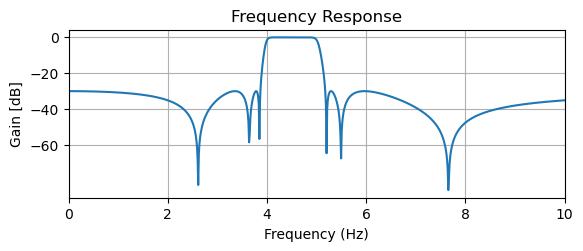

In [90]:
# filtering overall data into 1x, 2x, and 3x RPM data
fs = np.round(len(ugb_1x_time) / max(ugb_1x_time), 0)

dt = 1 / fs
fl = 4
fu = 5
transwidth = 0.2
f_band = np.array([fl, fu]) / (fs/2)
f_bands = [0, fl - transwidth, fl, fu, fu + transwidth, (fs/2)]
wp = [fl, fu]
ws = [fl - transwidth, fu + transwidth]

gpass = 1.5
gstop = 30
n, wn = buttord(wp, ws, gpass, gstop, fs=fs)
sos = butter(n, wn, 'bandpass', output='sos', fs=fs)

n, wn = cheb2ord(wp, ws, gpass, gstop, fs=fs)
sos = cheby2(n, 30, wn, 'bandpass', output='sos', fs=fs)

N = 16384
w,  h  = sosfreqz(sos, worN=N, fs=fs)

plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.xlim([0, 10])
plt.xlabel('Frequency (Hz)')

plt.show()

/usr/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


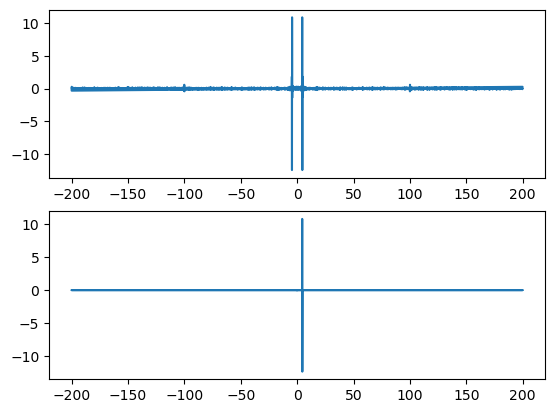

In [103]:
# apply filter FFT
def FFT_filter(time_data, signal, cut_off_frequency, fs):
    signal = signal - np.mean(signal)
    nfft = int(pow(2, np.ceil(np.log2(len(signal)))))
    win = np.hamming(len(signal))
    # freq = (fs/2) * np.arange(0,1,1/(nfft/2+1))
    freq = np.fft.fftfreq(signal.size, d=time_data[1]-time_data[0])
    
    ori_spectrum = 2/len(signal) * np.fft.fft(win*signal, nfft)

    # Select contents on the targetted frequencies
    new_spectrum = []
    for i in range(len(freq)):
        if freq[i] >= cut_off_frequency + 0.1 or freq[i] <= cut_off_frequency - 0.1:
            new_spectrum.append(0)
        else:
            new_spectrum.append(ori_spectrum[i])

    new_spectrum = np.array(new_spectrum)

    new_data = np.fft.ifft(new_spectrum / (1/len(signal)), nfft)
    # new_data = new_data[0:len(signal)]

    new_data = new_data / win

    return new_data, freq, ori_spectrum, new_spectrum, nfft

filtered_signal_x, freq, ori_spec, new_spec, nfft = FFT_filter(ugb_ovr_time, ugb_ovr_x, ugb_ovr_freq[0], fs)
filtered_signal_y, freq, ori_spec, new_spec, nfft = FFT_filter(ugb_ovr_time, ugb_ovr_y, ugb_ovr_freq[0], fs)

# plt.plot(ugb_ovr_time, filtered_signal_y)
plt.subplot(211)
plt.plot(freq, ori_spec)
plt.subplot(212)
plt.plot(freq, new_spec)
plt.show()


4096


Text(0.5, 0, 'Frequency (Hz)')

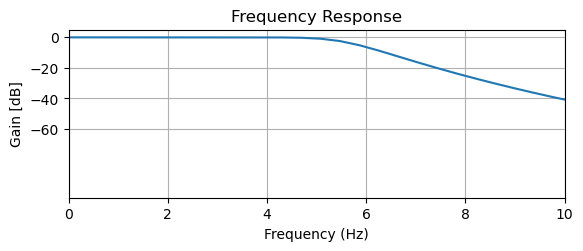

In [210]:
# apply low pass filter
cut_off_frequency = ugb_ovr_freq[0]
b, a = butter(8, cut_off_frequency+1, btype='lowpass', fs=fs)

pad_size = 4000

ugb_ovr_x = np.pad(ugb_ovr_x, (pad_size, pad_size), 'constant', constant_values=(0,0))
ugb_ovr_y = np.pad(ugb_ovr_y, (pad_size, pad_size), 'constant', constant_values=(0,0))

filtered_signal_x = filtfilt(b, a, ugb_ovr_x)[pad_size:-pad_size]
filtered_signal_y = filtfilt(b, a, ugb_ovr_y)[pad_size:-pad_size]

print(len(filtered_signal_x))

w, h = freqz(b,a, fs=fs)

plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.xlim([0, 10])
plt.xlabel('Frequency (Hz)')

4096


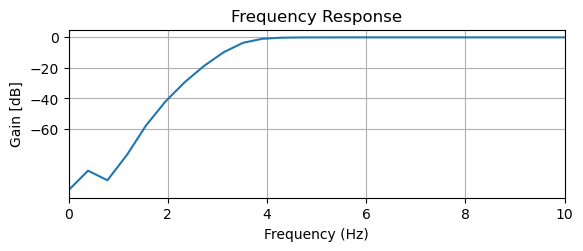

In [211]:
# apply low pass filter
cut_off_frequency = ugb_ovr_freq[0]
b, a = butter(8, cut_off_frequency-1, btype='highpass', fs=fs)

w, h = freqz(b,a, fs=fs)

plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w, db)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.xlim([0, 10])
plt.xlabel('Frequency (Hz)')

filtered_signal_x = np.pad(filtered_signal_x, (pad_size, pad_size), 'constant', constant_values=(0,0))
filtered_signal_y = np.pad(filtered_signal_y, (pad_size, pad_size), 'constant', constant_values=(0,0))

filtered_signal_x = filtfilt(b, a, filtered_signal_x)[pad_size:-pad_size]
filtered_signal_y = filtfilt(b, a, filtered_signal_y)[pad_size:-pad_size]

print(len(filtered_signal_x))


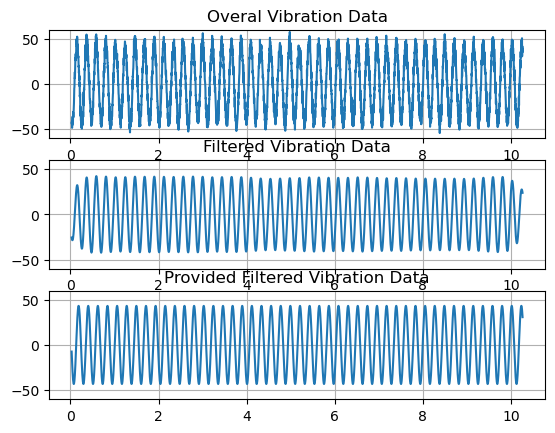

In [212]:
# Filtering the raw data and compare with the provided preliminary data
#filtered_signal_x = sosfiltfilt(sos, ugb_ovr_x)
#filtered_signal_y = sosfiltfilt(sos, ugb_ovr_y)

plt.subplot(3, 1, 1)
plt.plot(ugb_ovr_time, ugb_ovr_x[pad_size:-pad_size])
plt.grid(True)
plt.ylim([-60, 60])
plt.title("Overal Vibration Data")

plt.subplot(3, 1, 2)
plt.plot(ugb_ovr_time, filtered_signal_x)
plt.grid(True)
plt.ylim([-60, 60])
plt.title("Filtered Vibration Data")

plt.subplot(3, 1, 3)
plt.plot(ugb_ovr_time, ugb_1x_x)
plt.grid(True)
plt.ylim([-60, 60])
plt.title("Provided Filtered Vibration Data")

plt.show()

In [215]:
np.mean(filtered_signal_x-ugb_1x_x)

0.040929845087352125

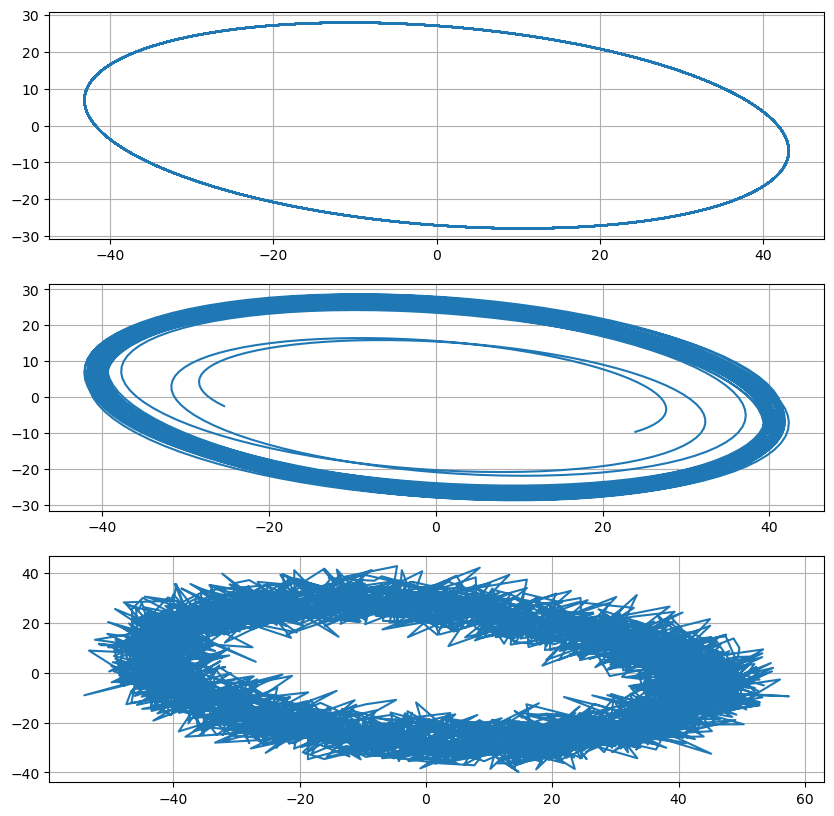

In [213]:
# extract and analyze the vibration data using orbital analysis

ugb_1x_time = db_data['UGB – Time – 1X']
ugb_1x_x = db_data['UGB – Disp – 1X – X']
ugb_1x_y = db_data['UGB – Disp – 1X – Y']

ugb_ovr_time = db_data['UGB – Time – Overall']
ugb_ovr_x = db_data['UGB – Disp – Overall – X']
ugb_ovr_y = db_data['UGB – Disp – Overall – Y']

# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax.plot(ugb_1x_x, ugb_1x_y)
plt.grid()

ax2 = fig.add_subplot(312)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax2.plot(filtered_signal_x, filtered_signal_y)
plt.grid()

ax3 = fig.add_subplot(313)
# ax.plot(ugb_ovr_x, ugb_ovr_y)
ax3.plot(ugb_ovr_x, ugb_ovr_y)
plt.grid()

plt.show()    

In [ ]:
# filtering the vibration data
def filter_vibration_data(raw_data, target_frequency, fs, order):
    filtered_data = np.zeros((order, len(raw_data)))

    for i in range(order):
        b_low, a_low = butter(8, (i+1)*target_frequency+1, btype='lowpass', fs=fs)
        b_high, a_high = butter(8, (i+1)*target_frequency-1, btype='highpass', fs=fs)

        x = filtfilt(b_low, a_low, raw_data)
        filtered_data[i:] = filtfilt(b_high, a_high, x)
    
    return filtered_data

ugb_x_filtered = filter_vibration_data(ugb_ovr_x, cut_off_frequency, fs, 2)
ugb_y_filtered = filter_vibration_data(ugb_ovr_y, cut_off_frequency, fs, 2)



## Recap on this section
The necessary analysis to observe on orbital domain are listed below
1. 1x amp (RMS) + phase
2. Phase shift (phase difference, amplitude ratio, coherence)
3. Order analysis (amplitude on its harmonic and sub-harmonic)
4. Order spectrum 
5. Centerline
6. Orbit-direct measurement
7. Filtered orbit

In [1]:
# import all necessary packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
import time
from scipy.signal import butter, buttord, sosfreqz, sosfilt, sosfiltfilt, cheb2ord, cheby2, firwin, freqz, firls, lfilter, iirpeak
from scipy.fft import rfft, irfft, fftfreq

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
from matplotlib import  gridspec

In [15]:
db_data = pd.read_excel("LGS1_VibrationOrbit_2023_HighLoad.xlsx", sheet_name="Orbit Comparison")

# data at 1x rpm
ugb_1x_rev = db_data['UGB – Rev – 1X']
ugb_1x_time = db_data['UGB – Time – 1X']
ugb_1x_x = db_data['UGB – Disp – 1X – X']
ugb_1x_y = db_data['UGB – Disp – 1X – Y']

# data on overall spectrum
ugb_ovr_rev = db_data['UGB – Rev – Overall']
ugb_ovr_time = db_data['UGB – Time – Overall']
ugb_ovr_x = db_data['UGB – Disp – Overall – X']
ugb_ovr_y = db_data['UGB – Disp – Overall – Y']

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(211)


In [ ]:
def extract_variable(data_directory):
    return 

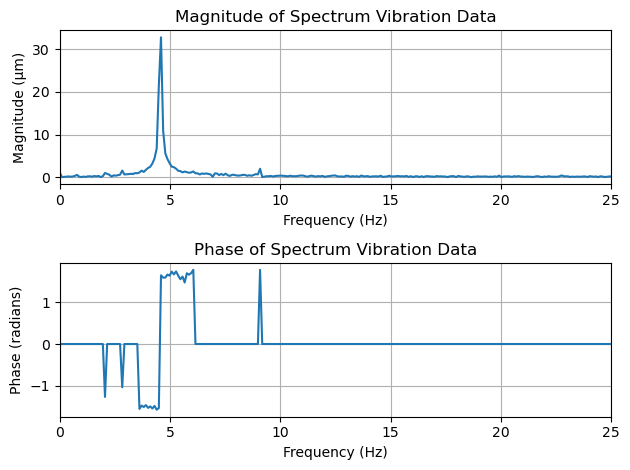

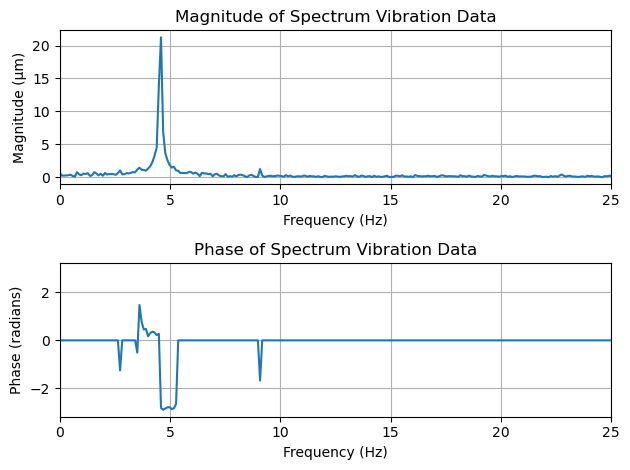

In [216]:
# define spectrum calculation of the displacement data
def fft_signal(time_data, value_data):
    # create window
    # win = np.hanning(len(value_data))

    # create frequency axis data
    freq = np.fft.fftfreq(len(value_data), time_data[1]-time_data[0])

    # apply fft
    spec = (2/len(value_data)) * np.fft.fft(value_data)

    return freq, spec

def plot_spectrum(freq_data, spec_data):
    idx = int(len(freq_data)/2)
    amp = np.abs(spec_data)
    phase = np.angle(spec_data)

    phase[amp < 1] = 0

    fig = plt.figure()
    ax_amp = fig.add_subplot(211)
    ax_amp.plot(freq_data[:idx], amp[:idx])
    ax_amp.set_xlim([0, 25])
    ax_amp.set_xlabel("Frequency (Hz)")
    ax_amp.set_ylabel(u"Magnitude (\u03bcm)")
    ax_amp.set_title("Magnitude of Spectrum Vibration Data")
    plt.grid(True)

    ax_phase = fig.add_subplot(212)
    ax_phase.plot(freq_data[:idx], phase[:idx])
    ax_phase.set_xlim([0, 25])
    ax_phase.set_xlabel("Frequency (Hz)")
    ax_phase.set_ylabel(u"Phase (radians)")
    ax_phase.set_title("Phase of Spectrum Vibration Data")
    plt.grid(True)

    plt.tight_layout()

# obtain the spectrum profile of each displacement data
ugb_ovr_x_spec = fft_signal(ugb_ovr_time, ugb_ovr_x)
ugb_ovr_y_spec = fft_signal(ugb_ovr_time, ugb_ovr_y)

# plot the spectrum data
plot_spectrum(ugb_ovr_x_spec[0], ugb_ovr_x_spec[1])
plot_spectrum(ugb_ovr_y_spec[0], ugb_ovr_y_spec[1])

In [87]:
# filter the overall signal into 1-5th order

def fft_signal_filtering(time_data, value_data, order, freq_target):
    # create window
    # win = np.hanning(len(value_data))

    # create frequency axis data
    freq = np.fft.fftfreq(len(value_data), time_data[1]-time_data[0])

    # apply fft
    spec = (2/len(value_data)) * np.fft.fft(value_data)

    value_data_filtered = np.zeros((order, len(value_data)))
    # apply rectangular filter
    for i in range(order):
        indices = (abs(freq) >= (i+1)*freq_target-1) & (abs(freq) <= (i+1)*freq_target+1)
        rect_filter = np.zeros_like(value_data)
        rect_filter[indices] = 1
        spec_filtered = spec * rect_filter
        value_data_filtered[i,:] = np.real(np.fft.ifft(spec_filtered / (2/len(value_data))))
        #value_data_filtered = value_data_filtered.real

    return freq, value_data_filtered

freq, ugb_ovr_x_filtered = fft_signal_filtering(ugb_ovr_time, ugb_ovr_x, 5, 4.5)
freq, ugb_ovr_y_filtered = fft_signal_filtering(ugb_ovr_time, ugb_ovr_y, 5, 4.5)
# ugb_ovr_x_spec_filtered = fft_signal(ugb_ovr_time, ugb_ovr_x_filtered[0,:])

# plot the spectrum data
# plot_spectrum(ugb_ovr_x_spec[0], ugb_ovr_x_spec[1])
# plot_spectrum(ugb_ovr_x_spec_filtered[0], ugb_ovr_x_spec_filtered[1])

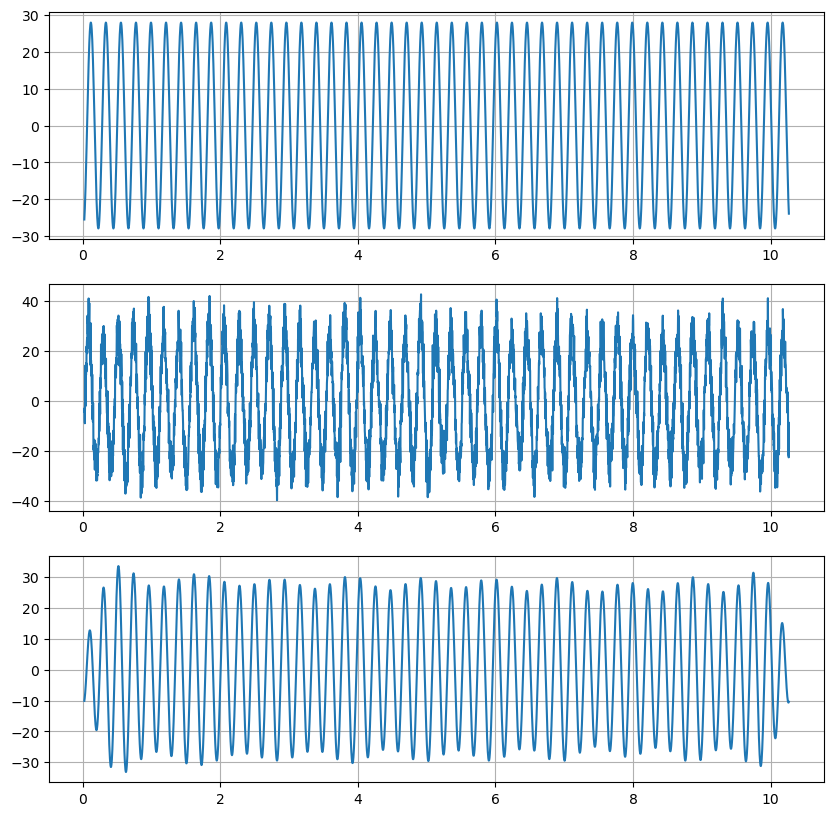

In [84]:
# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311)
ax.plot(ugb_ovr_time, ugb_1x_y)
plt.grid()

ax2 = fig.add_subplot(312)
ax2.plot(ugb_ovr_time, ugb_ovr_y)
plt.grid()

ax3 = fig.add_subplot(313)
ax3.plot(ugb_ovr_time, ugb_ovr_y_filtered[0,:])
plt.grid()

plt.show()  

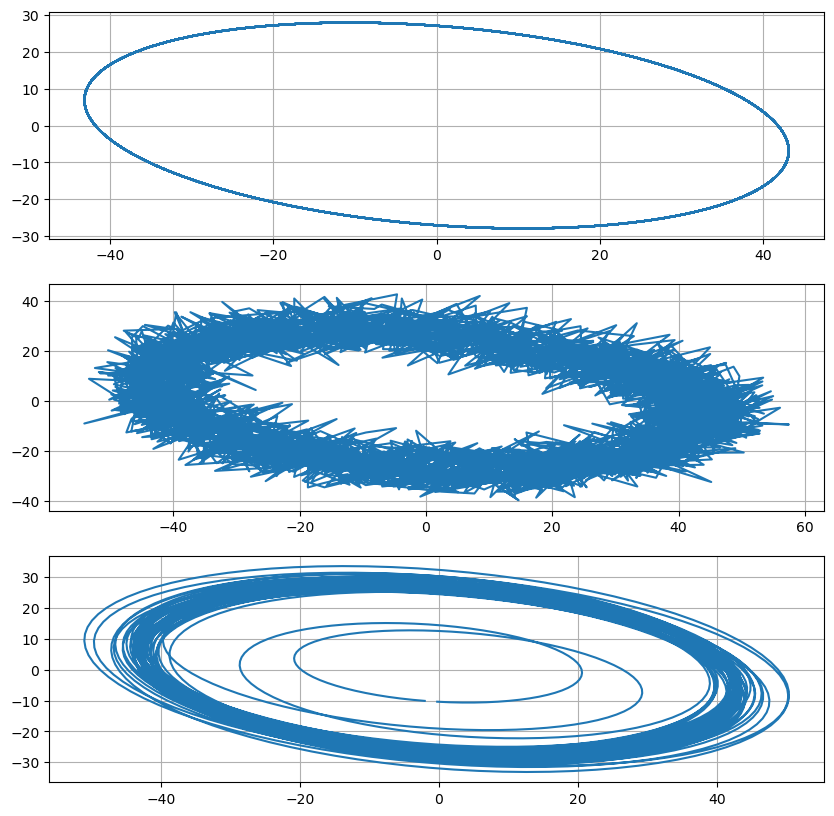

In [85]:
# plot the orbit of data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311)
ax.plot(ugb_1x_x, ugb_1x_y)
plt.grid()

ax2 = fig.add_subplot(312)
ax2.plot(ugb_ovr_x, ugb_ovr_y)
plt.grid()

ax3 = fig.add_subplot(313)
ax3.plot(ugb_ovr_x_filtered[0,:], ugb_ovr_y_filtered[0,:])
plt.grid()

plt.show()    

# 